# Lecture 05  
### Introduction to Cython - Part 02
### Feb 22, 2023    

---

Based on the material https://nyu-cds.github.io/python-cython/

This lecture provides a very brief introduction to Cython. See the [Cython documentation](http://cython.readthedocs.io/en/latest/) for a more detailed description of the Cython language.

----
## Cython for NumPy Users
NumPy can be used from Cython in exactly the same manner as in regular Python, however Cython also has a number of features that support fast access to NumPy arrays that can result in significant performance gains.

### Convolution -- Example Image Convolution 



Image processing uses convolution of an input image and corresponding kernel for blurring, sharpening, embossing, edge detection, etc. 

https://en.wikipedia.org/wiki/Kernel_(image_processing)


#### Convolution of two functions: $f \star g$

Discrete, on $\mathbf{Z}$: $$(f \star g) [n] = \sum_k f[k] g[n-k]$$

Continuous, on $\mathbf{R}$: $$(f \star g) (x) = \int f(t) g(x-t) d t $$

Continuous, on $\mathbf{R}^2$: $$(f \star g) (\vec{z}) = \iint f(\vec{u}) g(\vec{z}-\vec{u}) d \vec{u}$$




<!-- ![](https://miro.medium.com/max/790/1*1okwhewf5KCtIPaFib4XaA.gif) -->
<img src="https://miro.medium.com/max/790/1*1okwhewf5KCtIPaFib4XaA.gif" alt="Drawing" style="width: 200px;"/>

In [1]:
# Pure python code
import numpy as np

def naive_convolve(f, g):   
    # f is an image and is indexed by (i, j)
    # g is a filter kernel and is indexed by (x, y); it needs odd dimensions
    # h is the output image and is indexed by (i, j)
    
    if g.shape[0] % 2 != 1 or g.shape[1] % 2 != 1:
        raise ValueError("Only odd dimensions on filter supported")
    
    # dimensions of the image and filter
    (fx_max, fy_max) = f.shape
    (gx_max, gy_max) = g.shape
    
    # allocate the result image
    h = np.zeros([fx_max, fy_max], dtype=float)
    
    # do convolution
    for i in range(fx_max):
        for j in range(fy_max):
            # Calculate the pixel value h(i,j)             
            value = 0
            for x in range(0, min(i, gx_max)):
                for y in range(0, min(j, gy_max)):
                    value += g[x, y] * f[i - x, j - y]
            h[i, j] = value
    return h

652 ms ± 85.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


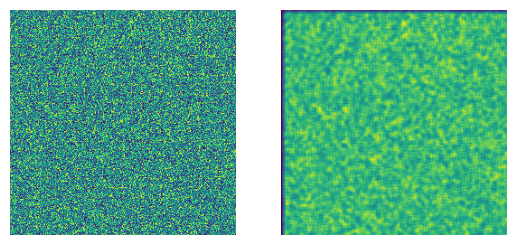

In [2]:
from matplotlib import pyplot as plt

I = np.random.uniform(low=0, high=1.0, size=((250, 250)))
G = np.ones((5, 5)) * (1/25)

%timeit naive_convolve(I, G)
H = naive_convolve(I, G)

plt.subplot(1, 2, 1)
plt.imshow(I)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(H)
plt.axis('off')

plt.show()

In [3]:
# using cython (the following code is identical to the previous on)
%load_ext Cython

In [4]:
%%cython

# Pure python code
import numpy as np

def naive_convolve_cython(f, g):   
    # f is an image and is indexed by (i, j)
    # g is a filter kernel and is indexed by (x, y); it needs odd dimensions
    # h is the output image and is indexed by (i, j)
    
    if g.shape[0] % 2 != 1 or g.shape[1] % 2 != 1:
        raise ValueError("Only odd dimensions on filter supported")
    
    # dimensions of the image and filter
    (fx_max, fy_max) = f.shape
    (gx_max, gy_max) = g.shape
    
    # allocate the result image
    h = np.zeros([fx_max, fy_max], dtype=float)
    
    # do convolution
    for i in range(fx_max):
        for j in range(fy_max):
            # Calculate the pixel value h(i,j)             
            value = 0
            for x in range(0, min(i, gx_max)):
                for y in range(0, min(j, gy_max)):
                    value += g[x, y] * f[i - x, j - y]
            h[i, j] = value
    return h

446 ms ± 12.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


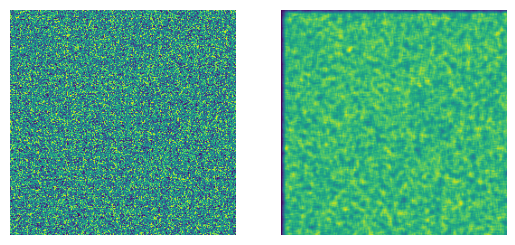

In [5]:
from matplotlib import pyplot as plt

Ic = np.random.uniform(low=0, high=1.0, size=((250, 250)))
Gc = np.ones((5, 5)) * (1/25)
%timeit naive_convolve_cython(Ic, Gc)
Hc = naive_convolve_cython(Ic, Gc)

plt.subplot(1, 2, 1)
plt.imshow(Ic)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(Hc)
plt.axis('off')

plt.show()

- We now add Cython data types to the code. The new code will no longer be compatible with Python.  

- The most important change is to use variables that have the same data type as the elements of the NumPy arrays.

In [6]:
# compiling with cython using ctypes
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [7]:
%%cython --annotate
import numpy as np
cimport numpy as np # need to import special compile-time information

def naive_convolve_cython_with_ctypes(np.ndarray f, np.ndarray g): # the arrays type are provided
    # f is an image and is indexed by (i, j)
    # g is a filter kernel and is indexed by (x, y); it needs odd dimensions
    # h is the output image and is indexed by (i, j)
    
    if g.shape[0] % 2 != 1 or g.shape[1] % 2 != 1:
        raise ValueError("Only odd dimensions on filter supported")
    
    # dimensions of the image and filter
    # the variables are stated now using cdef
    cdef int fx_max = f.shape[0]
    cdef int fy_max = f.shape[1]
    cdef int gx_max = g.shape[0]
    cdef int gy_max = g.shape[1]
    
    # stating the type of the variables in for-loops allows 
    # for a more optimized conversion to a C loop
    cdef int i  
    cdef int j
    cdef int x
    cdef int y
    cdef double value

    # allocate the result image
    cdef np.ndarray h = np.zeros([fx_max, fy_max], dtype=float)
    
    # do convolution
    for i in range(fx_max):
        for j in range(fy_max):
            # Calculate the pixel value h(i,j)             
            value = 0
            for x in range(0, min(i, gx_max)):
                for y in range(0, min(j, gy_max)):
                    value += g[x, y] * f[i - x, j - y]
            h[i, j] = value
    return h

In file included from /home/buzgalbraith/miniconda3/envs/advpy/lib/python3.8/site-packages/numpy/core/include/numpy/ndarraytypes.h:1948,
                 from /home/buzgalbraith/miniconda3/envs/advpy/lib/python3.8/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /home/buzgalbraith/miniconda3/envs/advpy/lib/python3.8/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from /home/buzgalbraith/.cache/ipython/cython/_cython_magic_0f9a30ce119101cb0aa4d07992a9f718.c:770:
/home/buzgalbraith/miniconda3/envs/advpy/lib/python3.8/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~


435 ms ± 21.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


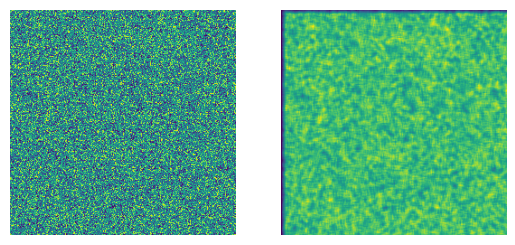

In [8]:
from matplotlib import pyplot as plt

Ict = np.random.uniform(low=0, high=1.0, size=((250, 250)))
Gct = np.ones((5, 5))* (1/25)
%timeit naive_convolve_cython_with_ctypes(Ict,Gct)
Hct = naive_convolve_cython_with_ctypes(Ict,Gct)

plt.subplot(1, 2, 1)
plt.imshow(Ict)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(Hct)
plt.axis('off')

plt.show()

### Efficient Indexing

- Still a bottleneck: the array lookups and assignments. 

- The []-operator still uses full Python operations;

- Instead access the data buffer directly (at the speed of C)

- Need to do is to type the contents of the ndarray objects; 

- We do this with a special “buffer” syntax which must be told:

- (i) the datatype (first argument), and 

- (ii) number of dimensions (“ndim” keyword-only argument, if not provided then one-dimensional is assumed).


In [9]:
# compiling with cython typing the content of ndarray objects
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [10]:
%%cython
import numpy as np
cimport numpy as np # need to import special compile-time information
# cimport cython

# @cython.boundscheck(False)
def naive_convolve_cython_with_ctypes_and_typing_ndarray(np.ndarray[double, ndim=2] f, 
                                                         np.ndarray[double, ndim=2] g): 
    # the arrays type are provided
    # f is an image and is indexed by (i, j)
    # g is a filter kernel and is indexed by (x, y); it needs odd dimensions
    # h is the output image and is indexed by (i, j)
    
    if g.shape[0] % 2 != 1 or g.shape[1] % 2 != 1:
        raise ValueError("Only odd dimensions on filter supported")
    
    # dimensions of the image and filter
    # the variables are stated now using cdef
    cdef int fx_max = f.shape[0]
    cdef int fy_max = f.shape[1]
    cdef int gx_max = g.shape[0]
    cdef int gy_max = g.shape[1]
    
    # stating the type of the variables in for-loops allows 
    # for a more optimized conversion to a C loop
    cdef int i  
    cdef int j
    cdef int x
    cdef int y
    cdef double value

    # allocate the result image
    cdef np.ndarray[double, ndim=2] h = np.zeros([fx_max, fy_max], dtype=float)
    
    # do convolution
    for i in range(fx_max):
        for j in range(fy_max):
            # Calculate the pixel value h(i,j)            
            value = 0
            for x in range(0, min(i, gx_max)):
                for y in range(0, min(j, gy_max)):
                    value += g[x, y] * f[i - x, j - y]
            h[i, j] = value
    return h

In file included from /home/buzgalbraith/miniconda3/envs/advpy/lib/python3.8/site-packages/numpy/core/include/numpy/ndarraytypes.h:1948,
                 from /home/buzgalbraith/miniconda3/envs/advpy/lib/python3.8/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /home/buzgalbraith/miniconda3/envs/advpy/lib/python3.8/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from /home/buzgalbraith/.cache/ipython/cython/_cython_magic_f6f3461baa15d5fdc9c9bdfac5a855d4.c:771:
/home/buzgalbraith/miniconda3/envs/advpy/lib/python3.8/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~


/tmp/ipykernel_17579/2070604833.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Gctt = (np.ones((5, 5)) * (1/25)).astype(np.float)


1.8 ms ± 49.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


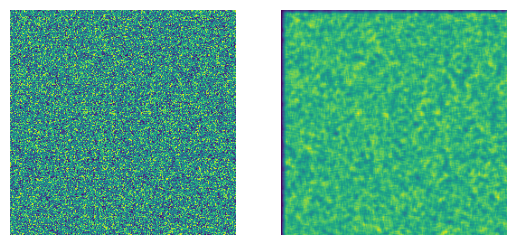

In [11]:
from matplotlib import pyplot as plt

Ictt = np.random.uniform(low=0, high=1.0, size=((250, 250))).astype(float)
Gctt = (np.ones((5, 5)) * (1/25)).astype(np.float)

%timeit naive_convolve_cython_with_ctypes_and_typing_ndarray(Ictt,Gctt)
Hctt = naive_convolve_cython_with_ctypes_and_typing_ndarray(Ictt,Gctt)

plt.subplot(1, 2, 1)
plt.imshow(Ictt)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(Hctt)
plt.axis('off')

plt.show()